In [16]:
from fractional_differentiation import fracDiff_FFD, find_min_stationary_d
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [23]:
prices = pd.read_csv(
    "../../data/prices_data.csv", index_col=0, parse_dates=["YYYYMMDD"]
)

In [24]:
prices[["DlyPrc"]]

,DlyPrc
PERMNO,
10078,76.500
10078,71.750
10078,71.875
10078,68.000
10078,71.875
...,...
93436,252.540
93436,256.610
93436,261.440


In [51]:
prices.isna().sum()

SecInfoStartDt          0
SecInfoEndDt            0
SecurityBegDt           0
SecurityEndDt           0
SecurityNm              0
Ticker               1418
PERMCO                  0
SICCD                   0
NAICS                   0
ICBIndustry             0
YYYYMMDD                0
DlyCalDt                0
DlyPrc               1173
DlyPrcFlg               0
DlyCap               1473
DlyCapFlg               0
DlyPrevPrc           1440
DlyPrevPrcFlg        1173
DlyPrevDt            1440
DlyPrevCap           1440
DlyPrevCapFlg        1173
DlyRetx              1443
DlyVol               1474
DlyClose            14731
DlyLow              14731
DlyHigh             14731
DlyBid              57383
DlyAsk              57383
DlyOpen             19808
DlyNumTrd         2970055
DlyPrcVol            1475
ShrOut                300
dtype: int64

In [44]:
x = prices.loc[93436, ["DlyPrc", "YYYYMMDD", "Ticker"]]
x.head()

,DlyPrc,YYYYMMDD,Ticker
PERMNO,,,
93436,23.89,2010-06-29,TSLA
93436,23.83,2010-06-30,TSLA
93436,21.96,2010-07-01,TSLA
93436,19.20,2010-07-02,TSLA
93436,16.11,2010-07-06,TSLA


<Axes: xlabel='YYYYMMDD'>

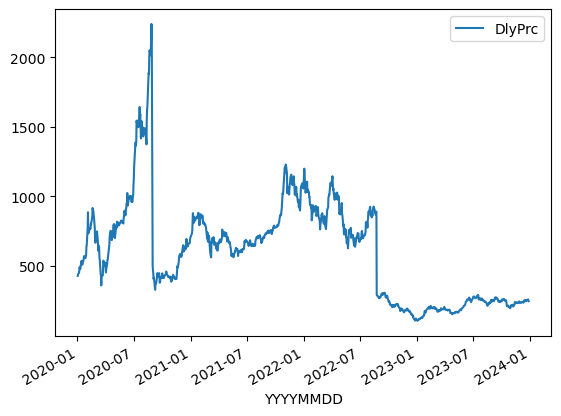

In [48]:
x[x.set_index("YYYYMMDD").index.year >= 2020].plot(x="YYYYMMDD", y="DlyPrc")

In [49]:
adfuller(
    x[x.set_index("YYYYMMDD").index.year >= 2020]["DlyPrc"],
    maxlag=1,
    regression="c",
    autolag=None,
)

(-2.868786784811168,
 0.049099930321660795,
 1,
 1004,
 {'1%': -3.436879978012783,
  '5%': -2.86442302475405,
  '10%': -2.568305057578451})